# Data preprocessing

## Setup

In [1]:
%%capture
%pip install -r ../requirements.txt

In [57]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from IPython.display import Image
from sklearn.preprocessing import StandardScaler

import tqdm # DO NOT REMOVE

%matplotlib inline

In [4]:
PROJECT_PATH = Path.joinpath(Path.cwd(), '..')
DATA_PATH = PROJECT_PATH / "data"
CSV_PATH = DATA_PATH / "gym_members_exercise_tracking.csv"

In [5]:
df = pd.read_csv(CSV_PATH)

In [59]:
df_casted = df.astype(copy=True, dtype={
    'Workout_Frequency (days/week)': 'category',
    'Experience_Level': 'category',
    'Workout_Type': 'category',
    'Gender': 'category'
})

## Data Cleaning

There are no missing values and duplicates. So we can move on to the next step.

## Outliers Handling

We have decided to remove the data points that don't follow the distribution of the data.

### Water_Intake and Fat_Percentage

In [33]:
df.__len__()

973

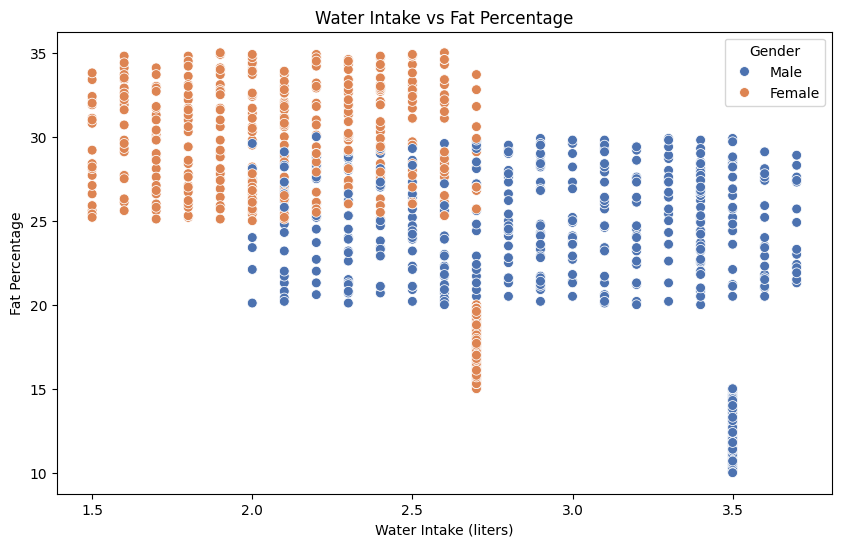

In [6]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Water_Intake (liters)", y="Fat_Percentage", hue="Gender", palette="deep", s=50)
plt.title("Water Intake vs Fat Percentage")
plt.xlabel("Water Intake (liters)")
plt.ylabel("Fat Percentage")
plt.show()

In [60]:
# Remove all rows where Gender is Male and Fat Percentage <= 15
df_filtered = df_casted[~((df_casted['Gender'] == 'Male') & (df_casted['Fat_Percentage'] <= 15))]
# Remove all rows where Gender is Female and Fat Percentage <= 20
df_filtered = df_filtered[~((df_filtered["Gender"] == "Female") & (df_filtered["Fat_Percentage"] <= 20))]

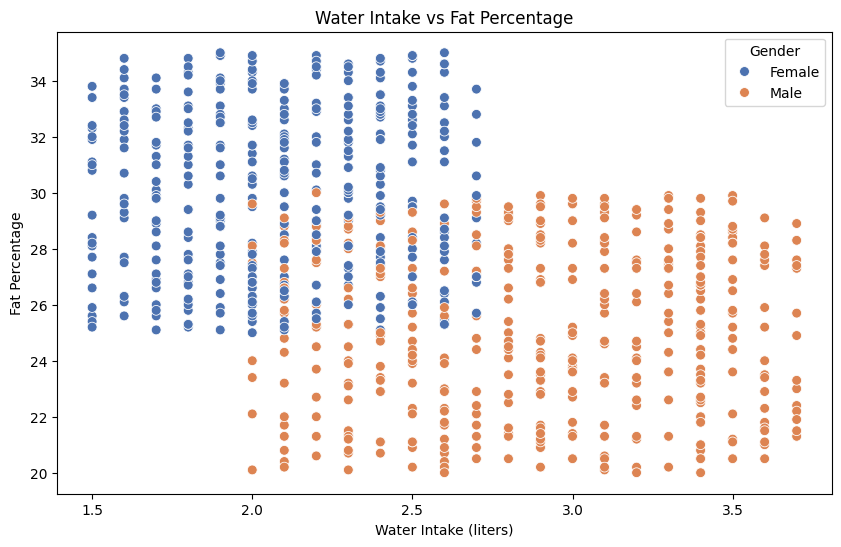

In [61]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtered, x="Water_Intake (liters)", y="Fat_Percentage", hue="Gender", palette="deep", s=50)
plt.title("Water Intake vs Fat Percentage")
plt.xlabel("Water Intake (liters)")
plt.ylabel("Fat Percentage")
plt.show()

In [62]:
df_filtered.__len__()

782

We are also going to remove the outliers following statistical methods (z-index and IQR).

#### Z-index

In [63]:
df_numerical = df_filtered.select_dtypes(include=[np.number])

# Calculate z-scores for all numerical columns
z_scores = df_numerical.apply(zscore)

# Find rows where any z-score is greater than 3 (outliers)
df_zscore_outliers =  df_filtered[(z_scores.abs() > 3).any(axis=1)]

# Filter the dataframe
df_zindex = df_filtered[(z_scores < 3).all(axis=1)]

df_zindex.__len__()

776

#### IQR

In [64]:
# Select only numerical columns for the IQR calculation
df_zindex_numerical = df_zindex.select_dtypes(include=[np.number])

# Calculate Q1 (25th percentile) and Q3 (75th percentile) for numerical columns
Q1_zindex = df_zindex_numerical.quantile(0.25)
Q3_zindex = df_zindex_numerical.quantile(0.75)
IQR_zindex = Q3_zindex - Q1_zindex

# Define the lower and upper bounds for outliers
lower_bound_zindex = Q1_zindex - 1.5 * IQR_zindex
upper_bound_zindex = Q3_zindex + 1.5 * IQR_zindex

# Filter the dataframe to remove outliers
df_no_outliers = df_zindex[~((df_zindex_numerical < lower_bound_zindex) | (df_zindex_numerical > upper_bound_zindex)).any(axis=1)]

# Get the length of the filtered dataframe
df_no_outliers.__len__()

749

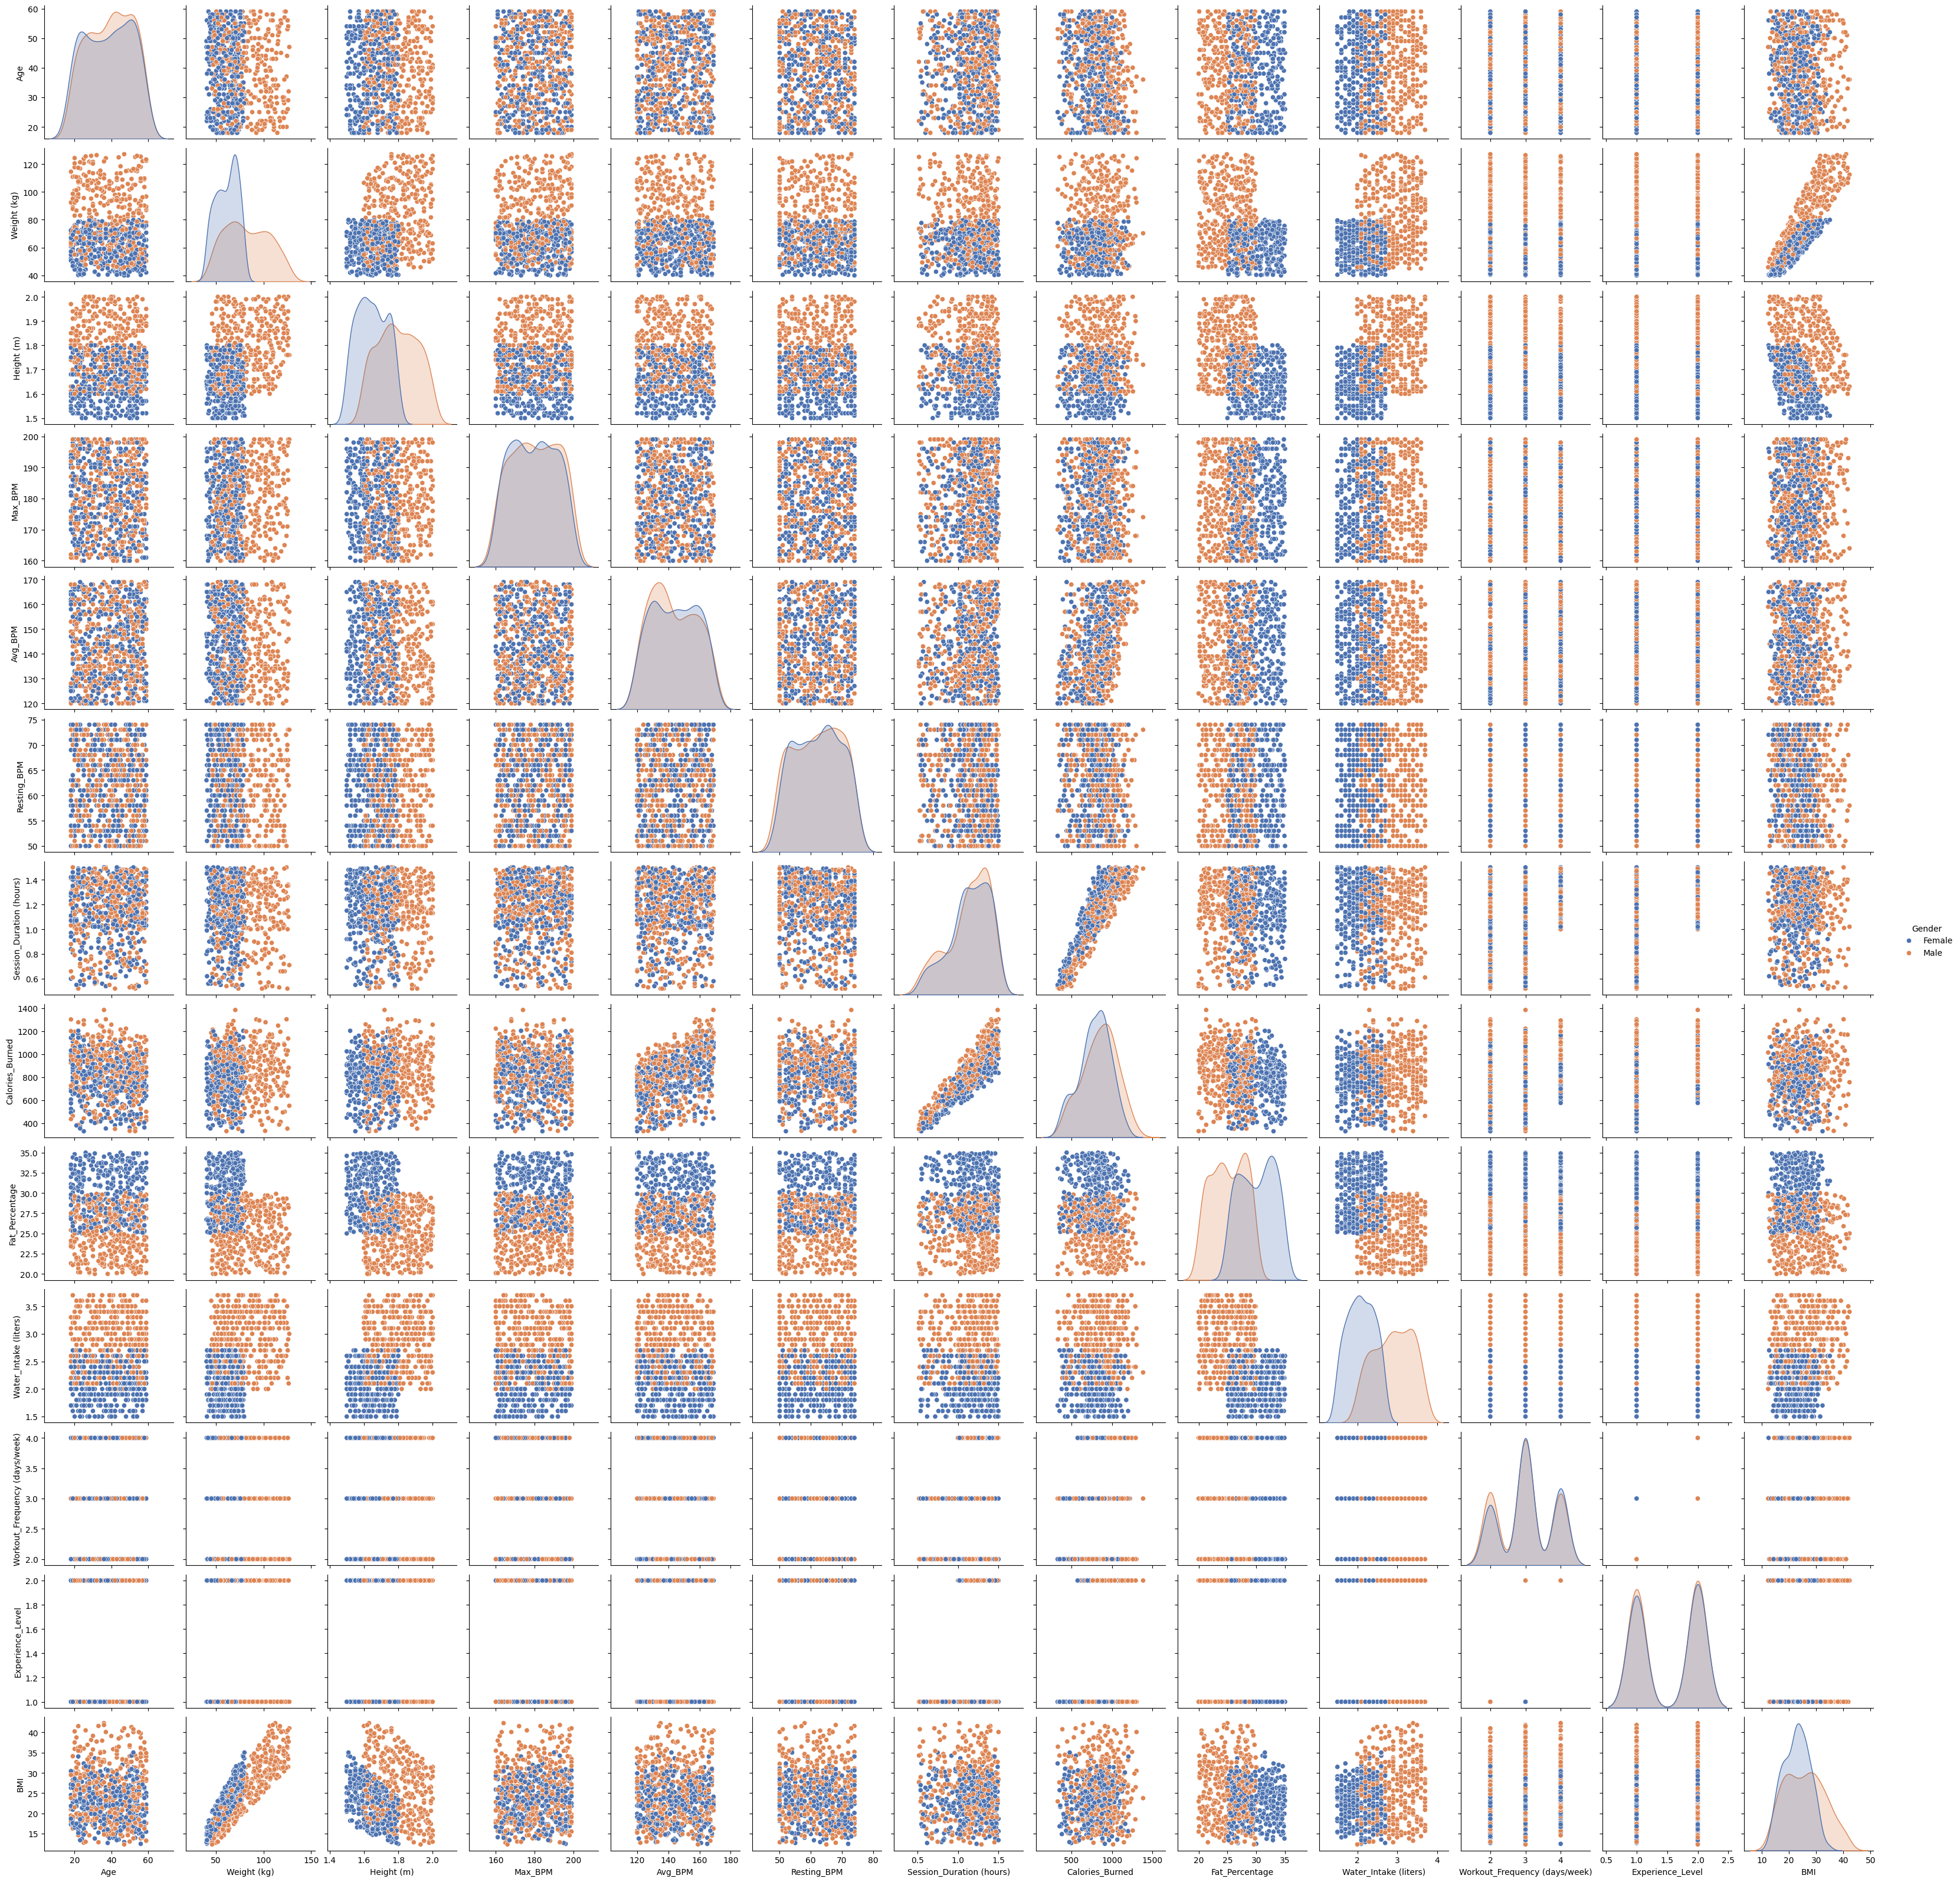

In [65]:
if not os.path.exists("images/pairplot-gender-no-outliers.png"):
    sns_plot = sns.pairplot(df_no_outliers, hue='Gender', palette='deep')
    sns_plot.savefig("images/pairplot-gender-no-outliers.png")
    plt.clf() 

Image(filename='images/pairplot-gender-no-outliers.png')

## Data Transformation

Because most of the features are normally distributed, we are going to use the StandardScaler to scale the data.

In [74]:
scaler = StandardScaler()
numerical_columns = df_no_outliers.select_dtypes(include=[np.number]).columns
df_no_outliers.loc[:, numerical_columns] = scaler.fit_transform(df_no_outliers[numerical_columns])
df_no_outliers.head()

Age  Gender  Weight (kg)  Height (m)   Max_BPM   Avg_BPM  Resting_BPM  \
1  0.585818  Female     0.126468   -1.526756 -0.075171  0.508902     0.521971   
2 -0.562600  Female    -0.197164   -0.495468 -1.116217 -1.504918    -1.105319   
3 -1.136809    Male    -0.906300   -0.178148  0.879121  1.411649    -0.834104   
4 -0.070421    Male    -1.244210    0.535821  0.705613  0.994997     0.793187   
6 -0.234480    Male    -0.092460   -0.019488 -0.508940  1.758859     1.471225   

   Session_Duration (hours)  Calories_Burned Workout_Type  Fat_Percentage  \
1                  0.643333         0.310791         HIIT        1.637633   
2                 -0.117198        -0.685783       Cardio        1.508069   
3                 -2.198650        -1.387255     Strength        0.316075   
4                 -1.998510        -1.271150     Strength        0.419727   
6                  1.403863         2.739336       Cardio       -1.627393   

   Water_Intake (liters) Workout_Frequency (days/week) Experience_Level  \
1              -0.689090                             4                2   
2              -0.344315                             4                2   
3              -0.689090                             3                1   
4               0.517623                             3                1   
6              -0.344315                             3                2   

        BMI  
1  1.203651  
2  0.058092  
3 -0.931898  
4 -1.563605  
6 -0.091192